In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

In [4]:
prep = pd.read_csv('/content/data.csv')
data = pd.read_csv('/content/data.csv')

In [5]:
prep.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [6]:
prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  int64  
 3   sku_id           150150 non-null  int64  
 4   total_price      150149 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 10.3+ MB


In [7]:
prep.isnull().sum()

,0
record_ID,0
week,0
store_id,0
sku_id,0
total_price,1
base_price,0
is_featured_sku,0
is_display_sku,0
units_sold,0


In [8]:
from sklearn.impute import SimpleImputer

In [9]:
numerical_fields = prep.select_dtypes(include=[np.number]).columns.tolist()
categorical_fields = prep.select_dtypes(include=['object']).columns.tolist()

imputer = SimpleImputer(strategy="mean")
prep[numerical_fields] = imputer.fit_transform(prep[numerical_fields])

for col in categorical_fields:
    prep[col].fillna(prep[col].mode()[0], inplace=True)

print("Missing values imputed!")

Missing values imputed!


<ipython-input-9-20e99ed8243e>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prep[col].fillna(prep[col].mode()[0], inplace=True)


In [10]:
prep['key'] = prep['week'].astype(str) + '_' + prep['store_id'].astype(str)

In [11]:
prep = prep.drop(['record_ID', 'week', 'store_id', 'sku_id', 'total_price',
                  'base_price', 'is_featured_sku', 'is_display_sku'], axis=1)
print("Dropped unnecessary columns.")

Dropped unnecessary columns.


In [12]:
prep.head()

,units_sold,key
0,20.0,17/01/11_8091.0
1,28.0,17/01/11_8091.0
2,19.0,17/01/11_8091.0
3,44.0,17/01/11_8091.0
4,52.0,17/01/11_8091.0


In [13]:
prep = prep.groupby('key').sum()
print("Grouped by 'key'.")

Grouped by 'key'.


In [36]:
prep['day_1'] = prep['units_sold'].shift(-1)
prep['day_2'] = prep['units_sold'].shift(-2)
prep['day_3'] = prep['units_sold'].shift(-3)
prep['day_4'] = prep['units_sold'].shift(-4)

prep = prep.dropna()
print("Lag features created and missing values removed.")


Lag features created and missing values removed.


<Axes: xlabel='key'>

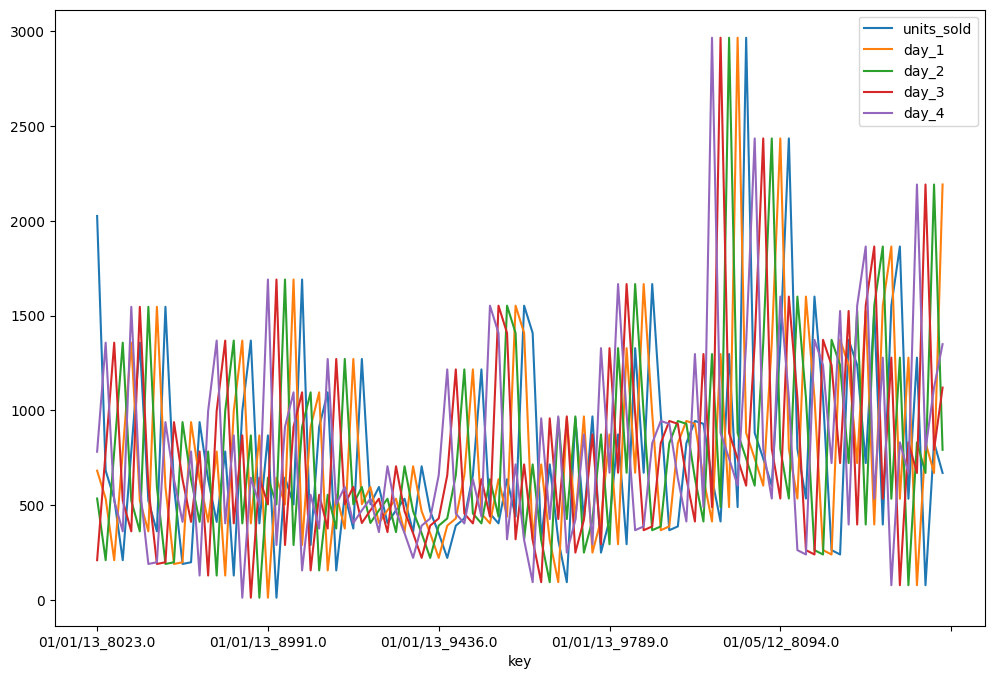

In [15]:
prep[:100].plot(figsize=(12,8))

**Train Test Split**

In [16]:
x1, x2, x3, x4, y =prep['day_1'],prep['day_2'],prep['day_3'],prep['day_4'],prep['units_sold']
x1, x2, x3, x4, y = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(y)
x1, x2, x3, x4, y = x1.reshape(-1,1), x2.reshape(-1,1), x3.reshape(-1,1), x4.reshape(-1,1), y.reshape(-1,1)

split_percentage = 15
test_split = int(len(prep)*(split_percentage/100))
x = np.concatenate((x1, x2, x3, x4), axis=1)
X_train,X_test,y_train,y_test = x[:-test_split],x[-test_split:],y[:-test_split],y[-test_split:]

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8395, 4)
(1481, 4)
(8395, 1)
(1481, 1)


# Random Forest Regression

In [21]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [22]:
print("R Sq. Score for Random Forest Regression :", rf_regressor.score(X_test, y_test))

R Sq. Score for Random Forest Regression : 0.6818702792912323


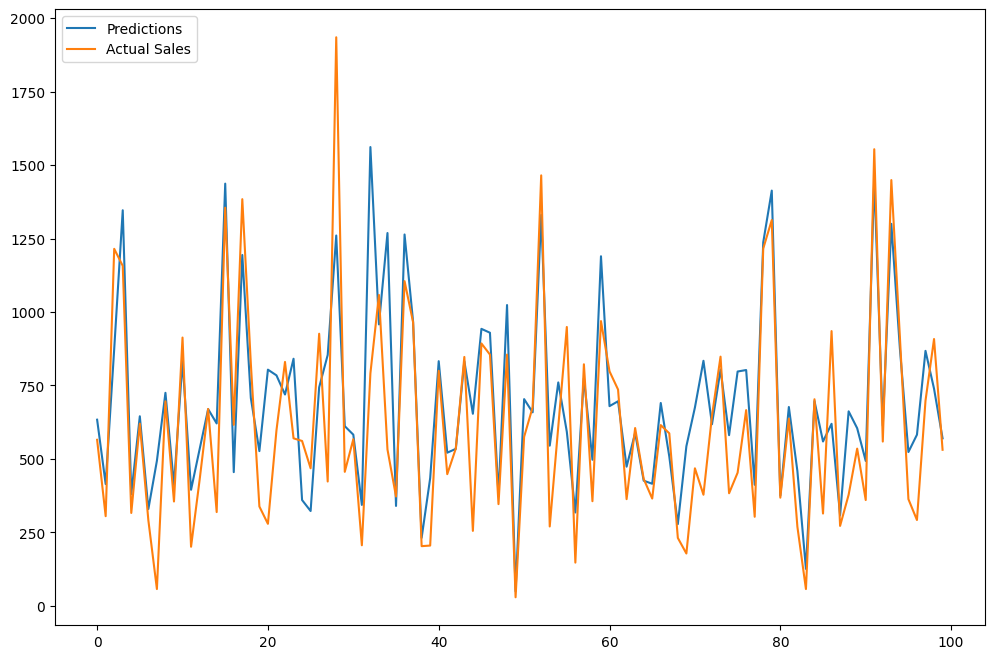

In [23]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(y_pred[-100:], label='Predictions')
plt.plot(y_test[-100:], label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

# **XGBoost Regression**

In [24]:
import xgboost
xgb_regressor = xgboost.XGBRegressor()
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

In [25]:
print("R Sq. Score for XGBoost :", xgb_regressor.score(X_test, y_test))

R Sq. Score for XGBoost : 0.5962779753990961


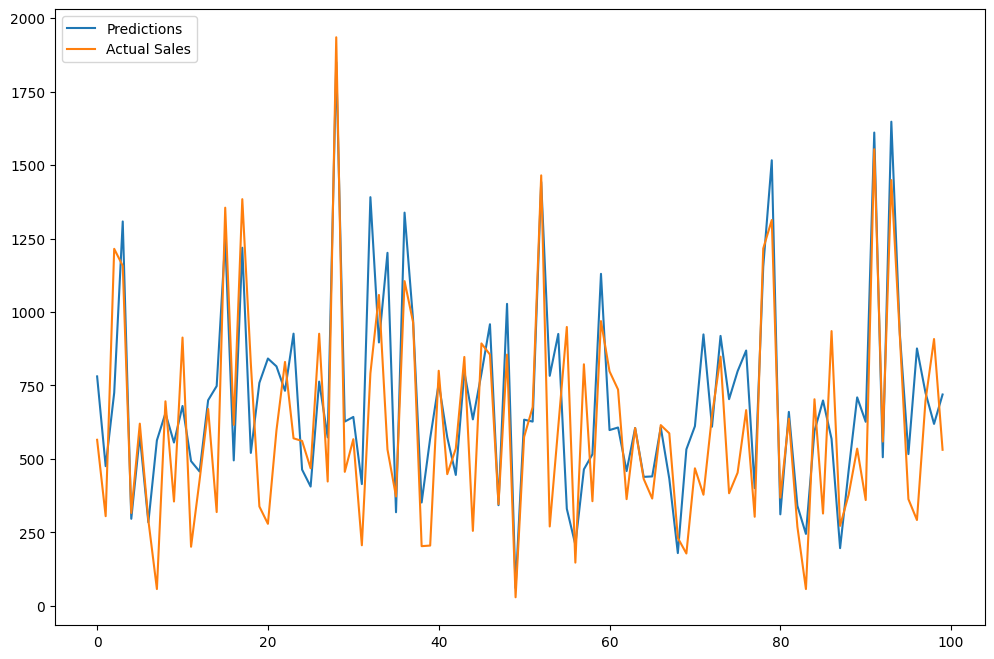

In [26]:
import matplotlib.pyplot as plt
plt.plot(y_pred[-100:], label='Predictions')
plt.plot(y_test[-100:], label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

# **Hyperparameter Tuning for Random Forest**

In [27]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 250, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(0, 120, num = 20)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 72, 94, 116, 138, 161, 183, 205, 227, 250], 'max_features': ['auto', 'sqrt'], 'max_depth': [0, 6, 12, 18, 25, 31, 37, 44, 50, 56, 63, 69, 75, 82, 88, 94, 101, 107, 113, 120, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [28]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=0, n_jobs = -1)

In [29]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
21 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_p

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [0, 6, 12, 18, 25, 31, 37,
                                                      44, 50, 56, 63, 69, 75,
                                                      82, 88, 94, 101, 107, 113,
                                                      120, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 72, 94, 116, 138,
                                                         161, 183, 205, 227,
                                                         250]},
                   random_state=0, verbose=2)

In [30]:
rf_random.best_params_

{'n_estimators': 205,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [31]:
best_random = rf_random.best_estimator_

In [32]:
y_pred = best_random.predict(X_test)

In [33]:
print("R Sq. Score for Random Forest Regression :", best_random.score(X_test, y_test))
print("Adj. R Sq. Score for Random Forest Regression :", 1 - (1 - best_random.score(X_test, y_test) ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 ))

R Sq. Score for Random Forest Regression : 0.6798494532048134
Adj. R Sq. Score for Random Forest Regression : 0.6789818365468319


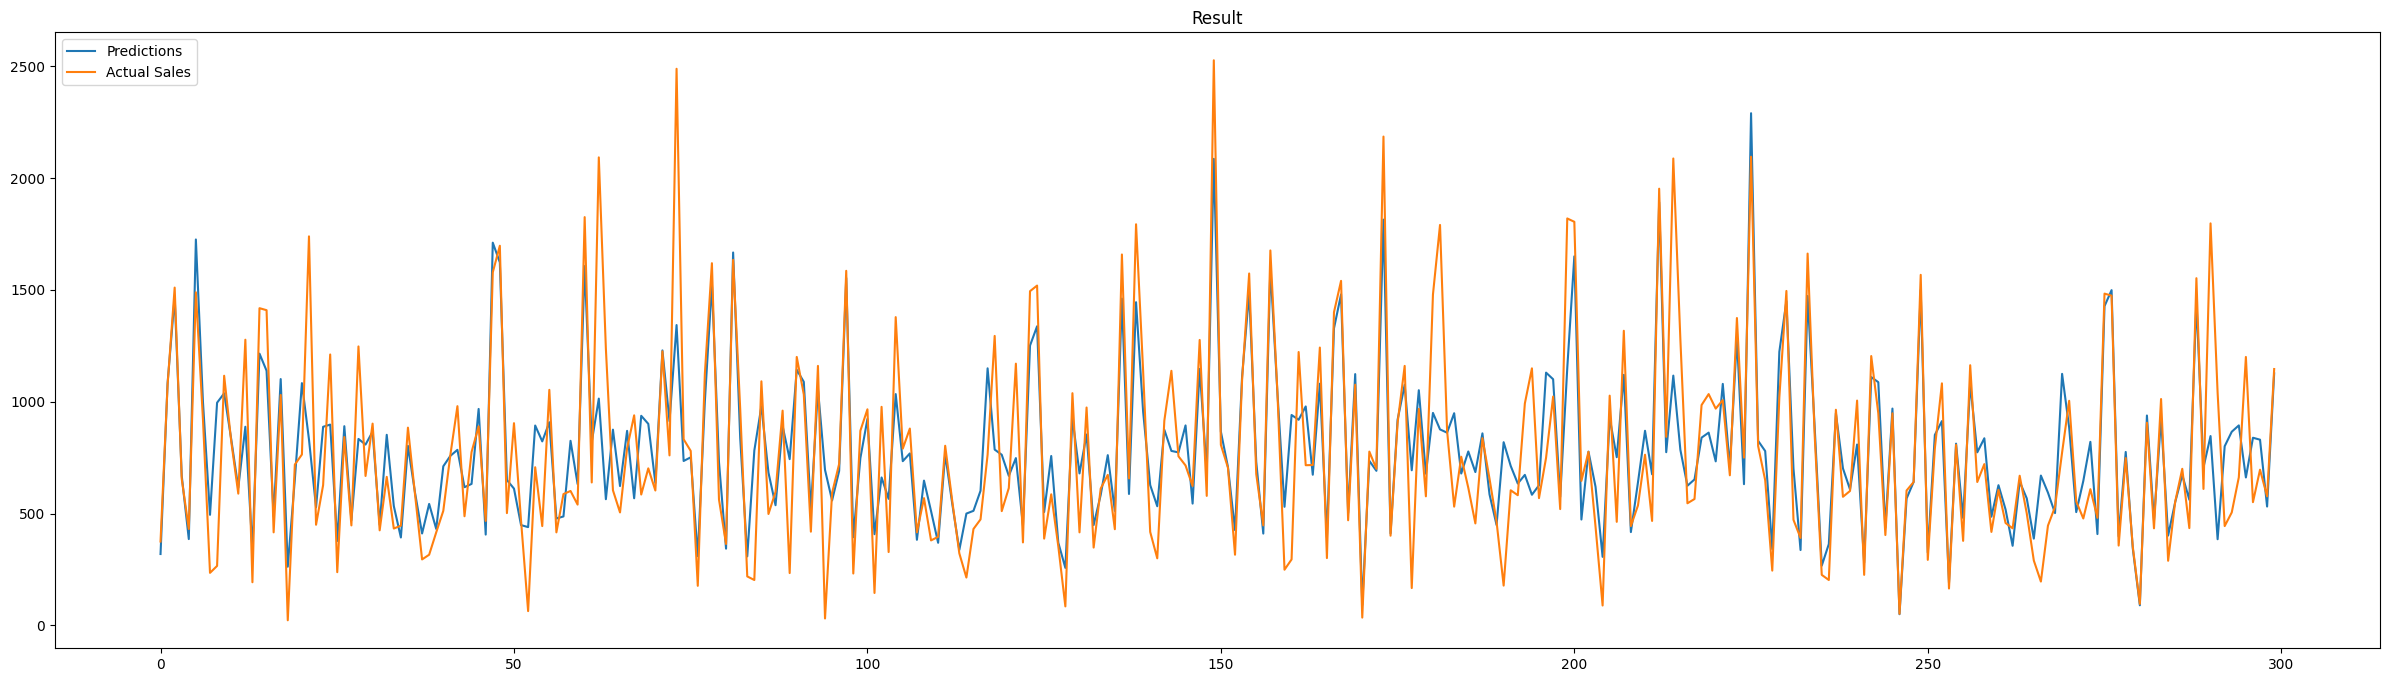

In [34]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,8)
plt.plot(y_pred[500:800], label='Predictions')
plt.plot(y_test[500:800], label='Actual Sales')
plt.title("Result")
plt.legend(loc="upper left")
plt.savefig('final.png')
plt.show()

Feature Engineering: Time-Based Features and Rolling
**Statistics**

In [35]:
data['week'] = pd.to_datetime(data['week'])

data['week_of_year'] = data['week'].dt.isocalendar().week

data['rolling_mean_7'] = data['units_sold'].rolling(window=7).mean()

data['rolling_sum_7'] =data['units_sold'].rolling(window=7).sum()

data[['rolling_mean_7', 'rolling_sum_7']] = data[['rolling_mean_7', 'rolling_sum_7']].fillna(0)

data['last_year_sales'] = data['units_sold'].shift(52)

data['year_over_year_change'] = (
    (data['units_sold'] - data['last_year_sales']) / data['last_year_sales']
)

data['year_over_year_change'] = data['year_over_year_change'].fillna(0)

print(data[['week', 'week_of_year', 'rolling_mean_7', 'rolling_sum_7', 'last_year_sales', 'year_over_year_change']].head(15))

         week  week_of_year  rolling_mean_7  rolling_sum_7  last_year_sales  \
0  2011-01-17             3        0.000000            0.0              NaN   
1  2011-01-17             3        0.000000            0.0              NaN   
2  2011-01-17             3        0.000000            0.0              NaN   
3  2011-01-17             3        0.000000            0.0              NaN   
4  2011-01-17             3        0.000000            0.0              NaN   
5  2011-01-17             3        0.000000            0.0              NaN   
6  2011-01-17             3       32.571429          228.0              NaN   
7  2011-01-17             3       36.857143          258.0              NaN   
8  2011-01-17             3       44.571429          312.0              NaN   
9  2011-01-17             3       56.000000          392.0              NaN   
10 2011-01-17             3       66.857143          468.0              NaN   
11 2011-01-17             3       65.142857         

<ipython-input-35-9f6203fc62df>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['week'] = pd.to_datetime(data['week'])
